<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./213_ltpy_IASI_L2_load_browse.ipynb"><< 213 - IASI - Level 2 - Load and browse </a><span style="float:right;"><a href="./23_ltpy_Sentinel5p_L2_data.ipynb">23 - Copernicus Sentinel-5 Precursor (Sentinel-5P) >></a></span>

# 2.2 AC SAF - GOME-2 - Data records (Level 3 products)

AC SAF GOME-2 data records are monthly aggregated products (Level 3), regridded onto a regular latitude longitude grid. Data records are disseminated in the data format `netCDF`. 

Data records are processed for three parameters:

* `tropospheric ozone column`, 
* `total and tropospheric nitrogen dioxide column`, and 
* `total water vapour column`.

This notebook guides you through how the data can be loaded and gives basic plotting examples.

#### Module outline:
* [1 - Load and browse AC SAF GOME-2 data records](#load_l3)
* [2 - Plotting example of AC SAF GOME-2 Level 3 data](#plotting)

#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
import datetime

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

<hr>

## <a id="load_l3"></a>Load and browse AC SAF data records

[NetCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) and [xarray](http://xarray.pydata.org/en/stable/) are two Python libraries to load and browse data who are disseminated in the `NetCDF` format.

### Open NetCDF files with the `NetCDF4` library

#### Open one individual file with `NetCDF4`

A NetCDF file can simply be loaded with the `Dataset` constructor of the NetCDF4 library.

In [2]:
dataset = Dataset('./eodata/gome2/level3/o3tropo/GOME_O3tropo_Tropics_201801_METOPA_DLR_v1.1.nc', format='NETCDF4')
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: tropospheric_ozone_column data
    Conventions: CF -1.6
    dimensions(sizes): latitude(32), longitude(144)
    variables(dimensions): float32 latitude(latitude), float32 longitude(longitude)
    groups: METADATA, PRODUCT

<br>

The dataset object contains information about the general data structure of the dataset. We see that the variables of AC SAF data records are organised in `groups`, which is analogous to directories in a filesystem. 

In order to see which variables are available in the dataset, we have to select the `PRODUCT` group of our dataset object.

In [3]:
dataset.groups['PRODUCT']

<class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): 
    variables(dimensions): float32 tropospheric_O3(latitude,longitude), float32 tropospheric_O3_std(latitude,longitude), int32 tropospheric_O3_number(latitude,longitude), float32 tropospheric_O3_mixingratio(latitude,longitude), float32 tropospheric_O3_mixingratio_std(latitude,longitude)
    groups: SUPPORT_DATA

<br>

The file contains five variables: 
* (1) `tropospheric_O`<sub>`3`</sub>, 
* (2) `tropospheric_O`<sub>`3`</sub>`_std`, 
* (3) `tropospheric_O`<sub>`3`</sub>`_number`, 
* (4) `tropospheric_O`<sub>`3`</sub>`_mixingratio` and 
* (5) `tropospheric_O`<sub>`3`</sub>`_mixingratio_std`

You can specify one variable of interest and get more detailed information about the variable. E.g. `tropospheric_O3` is the average column tropopshere mole content of ozone, has the unit DU, which stands for Dobson Unit and is a 2D variable on a latitude longitude grid.

In [4]:
dataset.groups['PRODUCT']['tropospheric_O3']

<class 'netCDF4._netCDF4.Variable'>
float32 tropospheric_O3(latitude, longitude)
    _FillValue: 9.96921e+36
    least_significant_digit: 2
    vertical_range_bottom: surface
    standard_name: troposphere_mole_content_of_ozone
    long_name: average column troposphere_mole_content_of_ozone
    units: DU
    vertical_range_top: 10_km
path = /PRODUCT
unlimited dimensions: 
current shape = (32, 144)
filling on

If you want to access the data values, you can retrieve it by indicating `[:]` - that means that you want to access the data array directly. You can do this for the variables, but also for the dimensions `latitude` and `longitude`.

You see that the `latitude` coordinates range between 19.375 N and -19.375 S and the `longitude` coordinates range between -178.75 W to 178.75 E.

In [5]:
o3 = dataset.groups['PRODUCT']['tropospheric_O3']
lat = dataset['latitude'][:]
lon = dataset['longitude'][:]

o3, lat, lon

(<class 'netCDF4._netCDF4.Variable'>
 float32 tropospheric_O3(latitude, longitude)
     _FillValue: 9.96921e+36
     least_significant_digit: 2
     vertical_range_bottom: surface
     standard_name: troposphere_mole_content_of_ozone
     long_name: average column troposphere_mole_content_of_ozone
     units: DU
     vertical_range_top: 10_km
 path = /PRODUCT
 unlimited dimensions: 
 current shape = (32, 144)
 filling on,
 masked_array(data=[-19.375, -18.125, -16.875, -15.625, -14.375, -13.125,
                    -11.875, -10.625,  -9.375,  -8.125,  -6.875,  -5.625,
                     -4.375,  -3.125,  -1.875,  -0.625,   0.625,   1.875,
                      3.125,   4.375,   5.625,   6.875,   8.125,   9.375,
                     10.625,  11.875,  13.125,  14.375,  15.625,  16.875,
                     18.125,  19.375],
              mask=False,
        fill_value=1e+20,
             dtype=float32),
 masked_array(data=[-178.75, -176.25, -173.75, -171.25, -168.75, -166.25,
          

<br>

### Open NetCDF files with `xarray`

#### Open one individual file with `xarray`

By using xarray's `open_dataset()` function, a `netCDF` file can be loaded to create a new xarray `Dataset`. You can have a look at the resulting `Dataset` and the `latitude` and `longitude` coordinates.

In [7]:
ds = xr.open_dataset('./eodata/gome2/level3/no2/GOME_NO2_Global_201701_METOPB_DLR_v1.nc')
ds, ds.latitude, ds.longitude

(<xarray.Dataset>
 Dimensions:    (latitude: 720, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Data variables:
     *empty*
 Attributes:
     description:  Level 3 NO2 data
     Conventions:  CF-1.6, <xarray.DataArray 'latitude' (latitude: 720)>
 array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
       dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
 Attributes:
     standard_name:  latitude
     long_name:      latitude_Centre, center of the grid box
     units:          degrees_north, <xarray.DataArray 'longitude' (longitude: 1440)>
 array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
       dtype=float32)
 Coordinates:
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Attributes:
     standard_name:  longitude
     long_name:    

<br>

You see that the `data variable` section is empty. This is due to the internal structure of the AC SAF GOME-2 Level 3 data. The data is organised in groups within the `netCDF` file. To load from a group, you have to pass the `group` keyword to the `open_dataset()` function. 

You can see that the `Dataset` contains six data variables:

* (1) `NO2total`, 
* (2) `NO2total_err`, 
* (3) `NO2total_stddev`, 
* (4) `NO2trop`,
* (5) `NO2trop_err`,
* (6) `NO2trop_stddev`

However, `latitude` and `longitude` do not contain any coordinates.

In [8]:
no2 = xr.open_dataset('./eodata/gome2/level3/no2/GOME_NO2_Global_201701_METOPB_DLR_v1.nc', group='PRODUCT')
no2, no2.latitude, no2.longitude

(<xarray.Dataset>
 Dimensions:          (latitude: 720, longitude: 1440)
 Dimensions without coordinates: latitude, longitude
 Data variables:
     NO2total         (latitude, longitude) float32 ...
     NO2total_err     (latitude, longitude) float32 ...
     NO2total_stddev  (latitude, longitude) float32 ...
     NO2trop          (latitude, longitude) float32 ...
     NO2trop_err      (latitude, longitude) float32 ...
     NO2trop_stddev   (latitude, longitude) float32 ...
     nobs             (latitude, longitude) float32 ...,
 <xarray.DataArray 'latitude' (latitude: 720)>
 array([  0,   1,   2, ..., 717, 718, 719])
 Dimensions without coordinates: latitude,
 <xarray.DataArray 'longitude' (longitude: 1440)>
 array([   0,    1,    2, ..., 1437, 1438, 1439])
 Dimensions without coordinates: longitude)

<br>

You can use the xarray function `assign_coords` to assign the coordinate values from your dataset to the dimensions of your group dataset.

In [9]:
no2_assigned = no2.assign_coords(latitude=ds.latitude, longitude=ds.longitude)
no2_assigned.NO2trop

<xarray.DataArray 'NO2trop' (latitude: 720, longitude: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
Attributes:
    long_name:      Tropospheric Column NO2 content
    units:          molec cm-2
    standard_name:  troposphere_mole_content_of_nitrogen_dioxide

<br>

#### Open multiple netCDF files with `xarray`

xarray's `open_mfdataset` function is very useful to load multiple netCDF files simultaneously. This function automatically concatenates and merges multiple files into a single xarray dataset. The behaviour of `open_mfdataset` is the same as the one of `open_dataset`. In order to access the dataset variables, you have to specify the `group` parameter. 

Additionally, if the dimension one want to concatenate the individual files is not defined in the original dataset, a new dimension can be defined by specifying the `concat_dim` key.

In [10]:
mf_dataset = xr.open_mfdataset('./eodata/gome2/level3/no2/*.nc', concat_dim='time', combine='nested',  group='PRODUCT')
mf_dataset

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Dimensions without coordinates: latitude, longitude, time
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

<br>

The resulting `Dataset` has three dimensions (`latitude`, `longitude` and `time`). With `assign_coords` you can assign the right coordinate values to the dimensions. You can use again the `ds` Dataset you defined at the beginning. 

With the help of Python's [pandas](https://pandas.pydata.org/) library, you can create efficiently a list of monthly time values, which can be assigned to the time dimension.

In [11]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-02', '2017-11', freq='MS').strftime("%Y-%m").tolist()

# Assign values to Dataset dimension
mf_dataset_assigned = mf_dataset.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
mf_dataset_assigned

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Coordinates:
  * latitude         (latitude) float32 -89.875 -89.625 ... 89.625 89.875
  * longitude        (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * time             (time) <U7 '2007-02' '2007-03' ... '2017-10' '2017-11'
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

<br>

## <a id="plotting"></a>Plotting example of AC SAF GOME-2 Level 3 data

### Plot `Dataset NetCDF` library object with `matplotlib` and `cartopy`

The retrieved `data array` from the `Dataset NetCDF` object is of type `numpy.MaskedArray`, which can be plotted with matplotlib's `imshow` function. The plot extent can be set with minimum and maximum values of the `latitude` and `longitude` information respectively.

We create a function [visualize_imshow](./ltpy_functions.ipynb#visualize_imshow), where we can specify `projection`, `extent`, `conversion_factor`, `color_scale`, `vmin`, `vmax`. We might want to re-use the function, thus we also add options to set a global extent and a logarithmic scaling of the colorbar.

In [12]:
def visualize_imshow(data_array, projection, extent, conversion_factor, color_scale, vmin, vmax, set_global=False, log_scale=False):
    """ 
    Visualizes a numpy MaskedArray with matplotlib's 'imshow' function.
    
    Parameters:
        data_array: any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        projection: a projection provided by the cartopy library, e.g. ccrs.PlateCarree()
        extent: list with the following order - [min(lon),max(lon),max(lat),min(lat)]
        conversion_factor(float): any number to convert the DataArray values
        color_scale(str): string taken from matplotlib's color ramp reference  
        vmin(int): minimum number on visualisation legend
        vmax(int): maximum number on visualisation legend
        set_global: set True, if the plot shall have a global coverage
        log_scale: set True, if the color_scale shall have a logarithmic scaling
    """
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=projection)
    ax.coastlines()
    ax.gridlines()
    if(set_global):
        ax.set_global()

    ax.set_title(data_array.long_name, fontsize=20, pad=20.0)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}
    
    if(log_scale):
        img1 = plt.imshow(data_array[:]*conversion_factor,
                          extent=extent,
                          cmap=color_scale,
                          aspect='auto',
                          norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    else:
        img1 = plt.imshow(data_array[:]*conversion_factor,
                          extent=extent,
                          cmap=color_scale,
                          vmin=vmin,
                          vmax=vmax,
                          aspect='auto')

    cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(str(conversion_factor) + ' ' + data_array.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    
    plt.show()

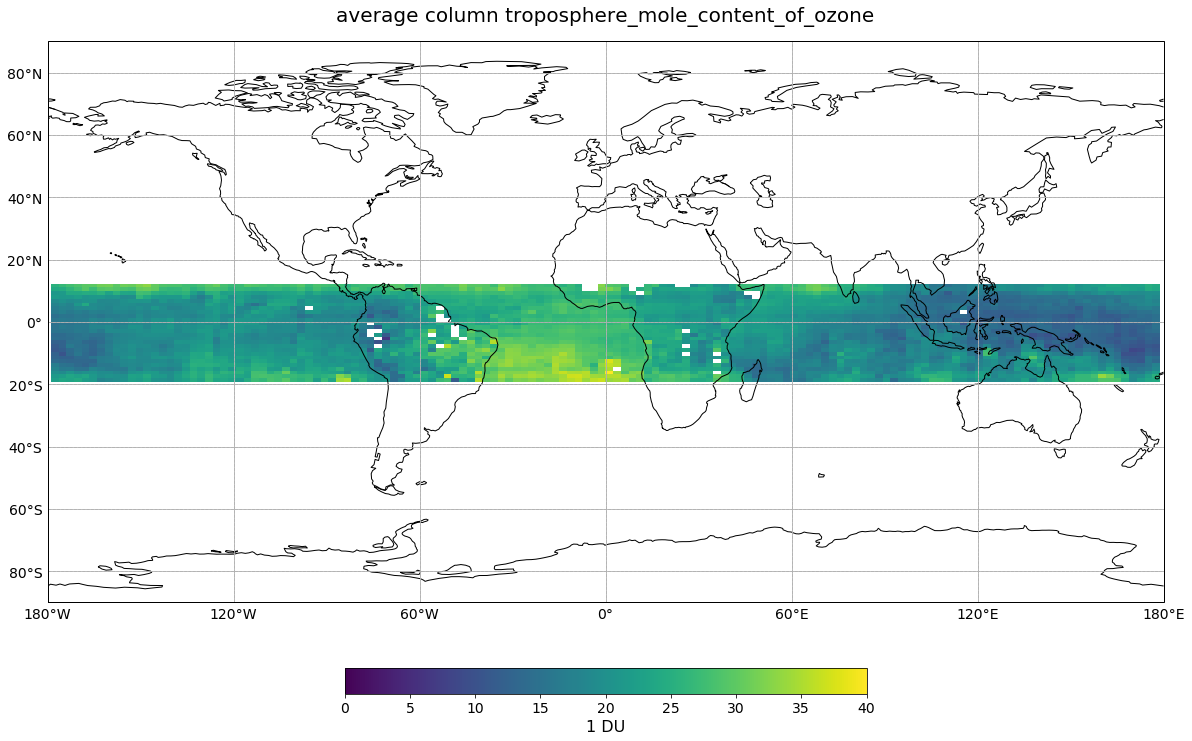

In [13]:
extent=[min(lon),max(lon),max(lat), min(lat)]

visualize_imshow(data_array=o3, projection=ccrs.PlateCarree(), extent=extent, conversion_factor=1, color_scale='viridis', vmin=0, vmax=40, set_global=True, log_scale=False)

<br>

### Plot xarray `Dataset` object with `matplotlib` and `cartopy`

You can use the function [visualize_imshow](./ltpy_functions.ipynb#visualize_imshow) which you defined above, also to visualize a xarray `Dataset`. You select the parameter of interest, e.g. `NO2total` and define the extent based on the `DataArray's` minimum and maximum latitude / longitude information.
These information are then taken to plot the total column NO<sub>2</sub> content.

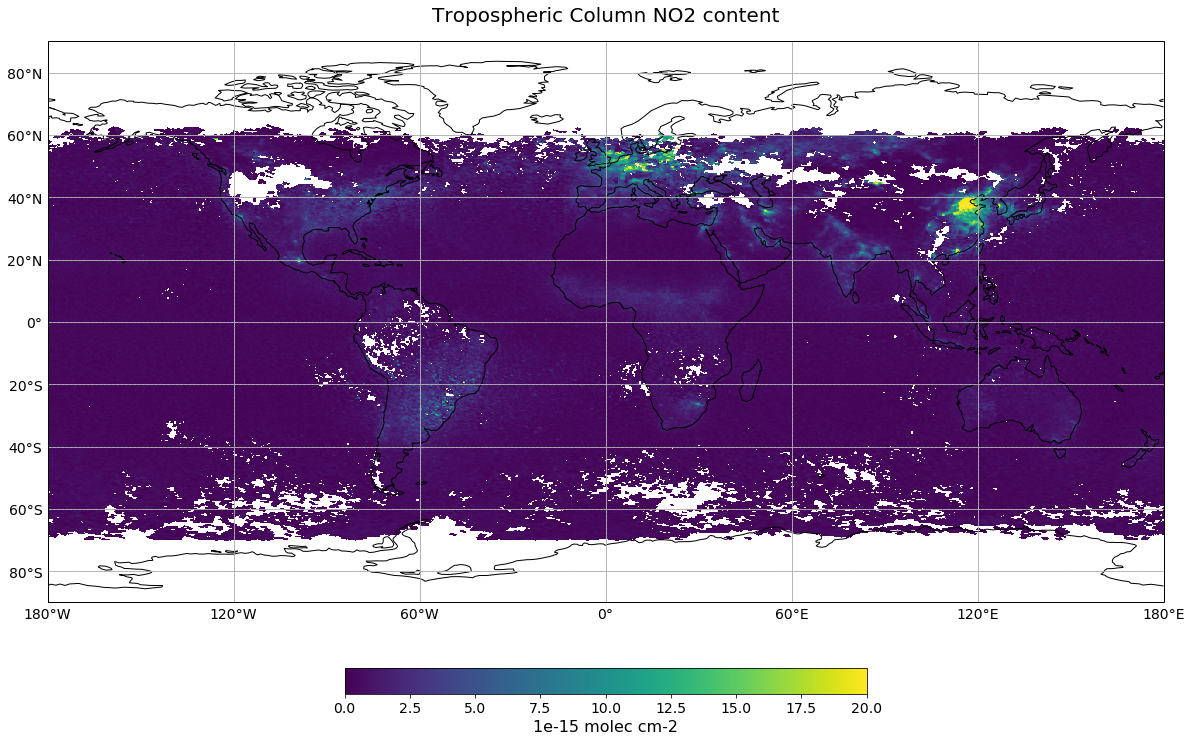

In [14]:
no2_da = no2_assigned.NO2trop

extent = [no2_da.longitude.min(),no2_da.longitude.max(),no2_da.latitude.max(),no2_da.latitude.min()]
visualize_imshow(no2_da, ccrs.PlateCarree(), extent, 1e-15, 'viridis', 0, 20, set_global=True, log_scale=False)

<br>

<a href="./213_ltpy_IASI_L2_load_browse.ipynb"><< 213 - IASI - Level 2 - Load and browse </a><span style="float:right;"><a href="./23_ltpy_Sentinel5p_L2_data.ipynb">23 - Copernicus Sentinel-5 Precursor (Sentinel-5P) >></a></span>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>